In [1]:
from IPython.display import display, HTML
from typing import List, Tuple, Dict, Any, Optional
from multiprocessing import Pool
from pandarallel import pandarallel
import os
import re
import sys
import json
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
from tqdm.auto import tqdm
tqdm.pandas()
pandarallel.initialize(progress_bar=True)

INFO: Pandarallel will run on 48 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


/home/ericzhou/miniconda3/envs/chaco/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Read All the Data

### Task Description: Validate and Process YAML Folders

#### Objective:
Develop a Python script or notebook that scans specified folders, validates YAML files based on specific criteria, and processes the data into a DataFrame.

---

#### Steps:
1. **Global Variable for Folders**:
   - Define a global variable containing the list of folders to scan (e.g., 003, 004).

2. **Folder Scanning**:
   - Recursively scan the specified folders and their subfolders.
   - Identify subfolders containing at least two YAML files.

3. **Validation**:
   - For each YAML file in a subfolder:
     - Check if the file contains a `score` field.
     - Ensure that none of the `score` values in the file are `0`.

4. **Folder Selection**:
   - Add the subfolder to a list (`folders_with_double_annotations`) if it contains at least two valid YAML files.

5. **DataFrame Creation**:
   - For each valid YAML file in the selected subfolders:
     - Parse the file into a record.
     - Include the folder path as a column in the record.
   - Combine all records into a single DataFrame.

6. **Output**:
   - Return the DataFrame.
   - Output the list of `folders_with_double_annotations`.


In [2]:
import yaml

# Global variable for folders to scan
folders_to_scan = ['reviews/003', 'reviews/004']

# External modular function for validation


def validate_yaml_file(data: Dict[str, Any]) -> bool:
    """
    Validate a YAML file based on specific criteria.

    Args:
        data (Dict[str, Any]): Parsed YAML data.

    Returns:
        bool: True if the YAML file is valid, False otherwise.
    """
    if 'scores' in data:
        return all(
            isinstance(score, dict) and
            'score' in score and
            score['score'] != 0
            for score in data['scores']
        )
    return False


def validate_and_process_yaml_folders(folders: List[str]) -> Tuple[pd.DataFrame, List[str]]:
    folders_with_double_annotations = []
    records = []

    for folder in folders:
        folder_path = Path(folder)
        if not folder_path.exists():
            print(f"Folder {folder} does not exist. Skipping...")
            continue

        # Recursively scan subfolders
        for subfolder in folder_path.rglob('*'):
            # print(f"Scanning folder: {subfolder}")
            if not subfolder.is_dir():
                continue

            yaml_files = list(subfolder.glob('*.yaml'))
            if len(yaml_files) < 2:
                continue

            valid_yaml_files = []
            for yaml_file in yaml_files:
                try:
                    with open(yaml_file, 'r') as f:
                        data = yaml.safe_load(f)

                    # Validate YAML file using an external modular function
                    if validate_yaml_file(data):
                        valid_yaml_files.append(yaml_file)

                except Exception as e:
                    print(f"Error reading {yaml_file}: {e}")

            if len(valid_yaml_files) >= 2:
                folders_with_double_annotations.append(str(subfolder))
                for valid_file in valid_yaml_files:
                    try:
                        record = {}
                        record['file_name'] = valid_file.name
                        record['folder_path'] = str(subfolder)
                        records.append(record)
                    except Exception as e:
                        print(f"Error processing {valid_file}: {e}")

    # Create DataFrame from records
    df = pd.DataFrame(records)
    return df, folders_with_double_annotations


# Execute the function
df, folders_with_double_annotations = validate_and_process_yaml_folders(
    folders_to_scan)

# Output the results
print("Folders with double annotations:", folders_with_double_annotations)
n_folders = len(folders_with_double_annotations)
print(f"Number of folders with double annotations: {n_folders}")
print("Processed DataFrame:")

# folder path: reviews/003/qiskit/14024/test_0 >> qiskit
df["project"] = df['folder_path'].apply(lambda x: x.split('/')[2])
df["pr_number"] = df['folder_path'].apply(lambda x: x.split('/')[3])

# yaml content
# reviewer: ez
# scores:
#   - criterion: "worthwhile"
#     score: 5
#     comment: "1st test could be parametrized"
#   - criterion: "well integrated"
#     score: 5
#     comment: ""
#   - criterion: "related to PR"
#     score: 5
#     comment: ""


def get_comments_and_scores(row):
    try:
        with open(Path(row['folder_path']) / row['file_name'], 'r') as f:
            data = yaml.safe_load(f)
        scores = {
            score['criterion']: score['score']
            for score in data.get('scores', [])}
        comments = {
            score['criterion']: score.get('comment', '')
            for score in data.get('scores', [])}
        return pd.Series([scores, comments])
    except Exception as e:
        print(f"Error reading {row['file_name']}: {e}")
        return pd.Series([{}, {}])


df[['scores', 'comments']] = df.progress_apply(get_comments_and_scores, axis=1)
# unpack scores and comments into separate columns
score_columns = df['scores'].apply(pd.Series)
comment_columns = df['comments'].apply(pd.Series)
df_raw_data = pd.concat([df, score_columns.add_prefix('score_'),
                         comment_columns.add_prefix('comment_')], axis=1)


display(df)
display(df_raw_data)

Folder reviews/003 does not exist. Skipping...
Folders with double annotations: ['reviews/004/pandas/60413/test_0', 'reviews/004/pandas/60505/test_0', 'reviews/004/pandas/60541/test_0', 'reviews/004/pandas/60637/test_0', 'reviews/004/pandas/60652/test_0', 'reviews/004/pandas/60713/test_0', 'reviews/004/pandas/60742/test_0', 'reviews/004/pandas/60940/test_0', 'reviews/004/pandas/61173/test_0', 'reviews/004/pandas/61173/test_1', 'reviews/004/qiskit/13530/test_0', 'reviews/004/qiskit/13539/test_0', 'reviews/004/qiskit/13624/test_0', 'reviews/004/qiskit/13922/test_0', 'reviews/004/qiskit/14132/test_0', 'reviews/004/qiskit/14143/test_0', 'reviews/004/qiskit/14217/test_0', 'reviews/004/qiskit/14275/test_0', 'reviews/004/qiskit/14417/test_0', 'reviews/004/qiskit/14529/test_0', 'reviews/004/scipy/22821/test_1', 'reviews/004/scipy/22855/test_0', 'reviews/004/scipy/22896/test_0', 'reviews/004/scipy/22896/test_1', 'reviews/004/scipy/22896/test_2', 'reviews/004/scipy/22946/test_0', 'reviews/004/sc

100%|██████████| 60/60 [00:00<00:00, 529.13it/s]


,file_name,folder_path,project,pr_number,scores,comments
0,scores_reviewer2.yaml,reviews/004/pandas/60413/test_0,pandas,60413,"{'worthwhile': 4, 'well integrated': 5, 'relat...",{'worthwhile': 'not really testing it end to e...
1,scores_reviewer1.yaml,reviews/004/pandas/60413/test_0,pandas,60413,"{'worthwhile': 4, 'well integrated': 5, 'relat...","{'worthwhile': '', 'well integrated': '', 'rel..."
2,scores_reviewer2.yaml,reviews/004/pandas/60505/test_0,pandas,60505,"{'worthwhile': 5, 'well integrated': 4, 'relat...","{'worthwhile': '', 'well integrated': 'Okay fi..."
3,scores_reviewer1.yaml,reviews/004/pandas/60505/test_0,pandas,60505,"{'worthwhile': 5, 'well integrated': 4, 'relat...",{'worthwhile': 'The PR adds a new test for thi...
4,scores_reviewer2.yaml,reviews/004/pandas/60541/test_0,pandas,60541,"{'worthwhile': 5, 'well integrated': 5, 'relat...","{'worthwhile': '', 'well integrated': 'using e..."
5,scores_reviewer1.yaml,reviews/004/pandas/60541/test_0,pandas,60541,"{'worthwhile': 4, 'well integrated': 5, 'relat...",{'worthwhile': 'Unclear if we need all 3 test ...
6,scores_reviewer2.yaml,reviews/004/pandas/60637/test_0,pandas,60637,"{'worthwhile': 4, 'well integrated': 5, 'relat...",{'worthwhile': 'the arrow test is a bit incomp...
7,scores_reviewer1.yaml,reviews/004/pandas/60637/test_0,pandas,60637,"{'worthwhile': 5, 'well integrated': 5, 'relat...","{'worthwhile': '', 'well integrated': '', 'rel..."
8,scores_reviewer2.yaml,reviews/004/pandas/60652/test_0,pandas,60652,"{'worthwhile': 5, 'well integrated': 5, 'relat...","{'worthwhile': '', 'well integrated': '', 'rel..."
9,scores_reviewer1.yaml,reviews/004/pandas/60652/test_0,pandas,60652,"{'worthwhile': 5, 'well integrated': 5, 'relat...","{'worthwhile': '', 'well integrated': '', 'rel..."


,file_name,folder_path,project,pr_number,scores,comments,score_worthwhile,score_well integrated,score_related to PR,comment_worthwhile,comment_well integrated,comment_related to PR
0,scores_reviewer2.yaml,reviews/004/pandas/60413/test_0,pandas,60413,"{'worthwhile': 4, 'well integrated': 5, 'relat...",{'worthwhile': 'not really testing it end to e...,4,5,5,not really testing it end to end because the f...,reasonable generic class for this high-level b...,
1,scores_reviewer1.yaml,reviews/004/pandas/60413/test_0,pandas,60413,"{'worthwhile': 4, 'well integrated': 5, 'relat...","{'worthwhile': '', 'well integrated': '', 'rel...",4,5,5,,,
2,scores_reviewer2.yaml,reviews/004/pandas/60505/test_0,pandas,60505,"{'worthwhile': 5, 'well integrated': 4, 'relat...","{'worthwhile': '', 'well integrated': 'Okay fi...",5,4,4,,"Okay file, but this could have been better: pa...","this seems to be a corner case, adjacent to th..."
3,scores_reviewer1.yaml,reviews/004/pandas/60505/test_0,pandas,60505,"{'worthwhile': 5, 'well integrated': 4, 'relat...",{'worthwhile': 'The PR adds a new test for thi...,5,4,5,The PR adds a new test for this line: test_gro...,"bad file, should have been in pandas/tests/gro...",
4,scores_reviewer2.yaml,reviews/004/pandas/60541/test_0,pandas,60541,"{'worthwhile': 5, 'well integrated': 5, 'relat...","{'worthwhile': '', 'well integrated': 'using e...",5,5,5,,using expr already defined and also option_con...,
5,scores_reviewer1.yaml,reviews/004/pandas/60541/test_0,pandas,60541,"{'worthwhile': 4, 'well integrated': 5, 'relat...",{'worthwhile': 'Unclear if we need all 3 test ...,4,5,5,"Unclear if we need all 3 test cases. Also, the...",,
6,scores_reviewer2.yaml,reviews/004/pandas/60637/test_0,pandas,60637,"{'worthwhile': 4, 'well integrated': 5, 'relat...",{'worthwhile': 'the arrow test is a bit incomp...,4,5,5,"the arrow test is a bit incomplete, and the na...",,
7,scores_reviewer1.yaml,reviews/004/pandas/60637/test_0,pandas,60637,"{'worthwhile': 5, 'well integrated': 5, 'relat...","{'worthwhile': '', 'well integrated': '', 'rel...",5,5,5,,,
8,scores_reviewer2.yaml,reviews/004/pandas/60652/test_0,pandas,60652,"{'worthwhile': 5, 'well integrated': 5, 'relat...","{'worthwhile': '', 'well integrated': '', 'rel...",5,5,5,,,
9,scores_reviewer1.yaml,reviews/004/pandas/60652/test_0,pandas,60652,"{'worthwhile': 5, 'well integrated': 5, 'relat...","{'worthwhile': '', 'well integrated': '', 'rel...",5,5,5,,,


In [3]:
# print the list of all comments columns skipping empty ones
comments_columns = [col for col in df_raw_data.columns if col.startswith(
    'comment_') and df_raw_data[col].str.strip().astype(bool).any()]
# print all comments one by one
for col in comments_columns:
    print(f"Comments in {col}:")
    for comment in df_raw_data[col].dropna().unique():
        if comment.strip():  # Skip empty comments
            print(f"- {comment.strip()}")
    print("\n")  # Add a newline for better readability

Comments in comment_worthwhile:
- not really testing it end to end because the flag pa_version_under10p1 is mocked but I think it is still fine to test the exception handling
- The PR adds a new test for this line: test_groupby_apply_empty_with_group_keys_false. Not sure why coverage is missing. Needs double check.
- Unclear if we need all 3 test cases. Also, there is another test 'test_bool_ops_warn_on_arithmetic' that seems to cover similar ground. Need to double check this
- the arrow test is a bit incomplete, and the name is misleading, but there are two other good tests.
- reasonable conversion test
- two assertions that are very similar, not sure how they differ in depth
- one test seems the same as the first, 2 good one repetition where the invalid input is a int instead of a string
- odd inputs but of for exceptions
- reasoning on more complex assertions is good
- Good. But the good test for valid phase is probably not necessary
- good check of the behavior, the oracle could be

Annotations in folder: reviews/004
Average score for score_worthwhile: 4.53
Average score for score_well integrated: 4.20
Average score for score_related to PR: 4.70

Scores DataFrame for score_worthwhile:


,folder_path,scores_reviewer1.yaml,scores_reviewer2.yaml
0,reviews/004/pandas/60413/test_0,4.0,4.0
1,reviews/004/pandas/60505/test_0,5.0,5.0
2,reviews/004/pandas/60541/test_0,4.0,5.0
3,reviews/004/pandas/60637/test_0,5.0,4.0
4,reviews/004/pandas/60652/test_0,5.0,5.0
5,reviews/004/pandas/60713/test_0,4.0,5.0
6,reviews/004/pandas/60742/test_0,4.0,5.0
7,reviews/004/pandas/60940/test_0,5.0,5.0
8,reviews/004/pandas/61173/test_0,4.0,5.0
9,reviews/004/pandas/61173/test_1,4.0,5.0



Scores DataFrame for score_well integrated:


,folder_path,scores_reviewer1.yaml,scores_reviewer2.yaml
0,reviews/004/pandas/60413/test_0,5.0,5.0
1,reviews/004/pandas/60505/test_0,4.0,4.0
2,reviews/004/pandas/60541/test_0,5.0,5.0
3,reviews/004/pandas/60637/test_0,5.0,5.0
4,reviews/004/pandas/60652/test_0,5.0,5.0
5,reviews/004/pandas/60713/test_0,4.0,5.0
6,reviews/004/pandas/60742/test_0,4.0,4.0
7,reviews/004/pandas/60940/test_0,5.0,5.0
8,reviews/004/pandas/61173/test_0,5.0,2.0
9,reviews/004/pandas/61173/test_1,5.0,2.0



Scores DataFrame for score_related to PR:


,folder_path,scores_reviewer1.yaml,scores_reviewer2.yaml
0,reviews/004/pandas/60413/test_0,5.0,5.0
1,reviews/004/pandas/60505/test_0,5.0,4.0
2,reviews/004/pandas/60541/test_0,5.0,5.0
3,reviews/004/pandas/60637/test_0,5.0,5.0
4,reviews/004/pandas/60652/test_0,5.0,5.0
5,reviews/004/pandas/60713/test_0,5.0,5.0
6,reviews/004/pandas/60742/test_0,5.0,5.0
7,reviews/004/pandas/60940/test_0,5.0,5.0
8,reviews/004/pandas/61173/test_0,5.0,3.0
9,reviews/004/pandas/61173/test_1,5.0,3.0


\newcommand{\avgScoreWorthwhile}{4.53}
\newcommand{\avgScoreWellIntegrated}{4.20}
\newcommand{\avgScoreRelatedToPr}{4.70}
\newcommand{\percAgrWorthwhile}{60.00\%}
\newcommand{\percAgrWellIntegrated}{66.67\%}
\newcommand{\percAgrRelatedToPr}{66.67\%}


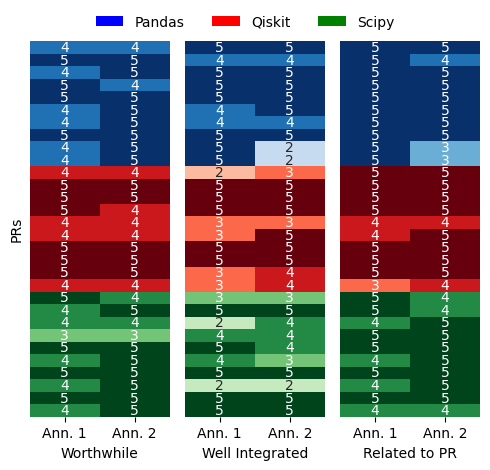

In [4]:
import numpy as np
import seaborn as sns
from matplotlib.patches import Patch


# for each column in df.columns starting with score_
# create a new df that contains the folder_path and the list of scores corresponding to the same folder_path
def create_scores_df(
        df: pd.DataFrame, score_column_prefix: str) -> pd.DataFrame:
    """
    Create a DataFrame containing folder_path and scores for a specific score column prefix.

    Args:
        df (pd.DataFrame): The input DataFrame.
        score_column_prefix (str): The prefix of the score columns to filter.

    Returns:
        pd.DataFrame: A DataFrame with folder_path and scores.
    """
    # group by folder_path and aggregate scores in a list
    df = df.copy()
    df["annotator_name"] = df['file_name']
    df["score"] = df[score_column_prefix].astype(float)
    # compute the average score
    average = df["score"].mean()
    print(f"Average score for {score_column_prefix}: {average:.2f}")
    # pivot and put the annotator_name as columns
    scores_df = df.pivot_table(
        index=["folder_path"],
        columns="annotator_name",
        values="score"
    ).reset_index()
    # rename columns to have score_ prefix
    scores_df.columns.name = None  # remove the name of the columns
    # scores_df.columns = ['item_to_annotate', 'folder_path'] + [
    #     f'score_{col}' for col in scores_df.columns[2:]]
    # sort by folder_path
    scores_df = scores_df.sort_values(by='folder_path').reset_index(drop=True)
    return scores_df


EXPERIMENTAL_FOLDER = 'reviews/004'
df_only_new_exp = df_raw_data[
    df_raw_data['folder_path'].str.contains(EXPERIMENTAL_FOLDER)]

DF_FOR_AGREEMENT = df_only_new_exp.copy()
print("Annotations in folder:", EXPERIMENTAL_FOLDER)

NAMES = {
    "score_worthwhile": "Worthwhile",
    "score_well integrated": "Well Integrated",
    "score_related to PR": "Related to PR"
}

# Create a DataFrame for each score column
score_columns = [col for col in DF_FOR_AGREEMENT.columns
                 if col.startswith('score_')]
scores_dfs = {}
for score_column in score_columns:
    i_df = create_scores_df(DF_FOR_AGREEMENT, score_column)
    i_df.sort_values(by='folder_path', inplace=True)
    scores_dfs[score_column] = i_df
# Display the scores DataFrames
for score_column, scores_df in scores_dfs.items():
    print(f"\nScores DataFrame for {score_column}:")
    display(scores_df)

# Define a dictionary for configurable colors and gradients
color_config = {
    "pandas": {"solid": "blue", "gradient": "Blues"},
    "qiskit": {"solid": "red", "gradient": "Reds"},
    "scipy": {"solid": "green", "gradient": "Greens"}
}

# Create a figure with three heatmaps where I consider the second and third col of each df
fig, axes = plt.subplots(
    nrows=1, ncols=len(scores_dfs),
    figsize=(5, 4.5),
    sharex=True, sharey=True)
i = 0
for ax, (score_column, scores_df) in zip(axes, scores_dfs.items()):
    # Only show colorbar for the last heatmap
    # show_colorbar = (i == len(scores_dfs) - 1)
    show_colorbar = False

    # Create a custom mask for each group of 10 rows
    mask_blues = np.zeros_like(scores_df.iloc[:, 1:], dtype=bool)
    mask_reds = np.zeros_like(scores_df.iloc[:, 1:], dtype=bool)
    mask_greens = np.zeros_like(scores_df.iloc[:, 1:], dtype=bool)
    mask_grays = np.zeros_like(scores_df.iloc[:, 1:], dtype=bool)

    # Set masks for different row groups
    if len(scores_df) > 0:
        mask_blues[:10, :] = True
    if len(scores_df) > 10:
        mask_reds[10:20, :] = True
    if len(scores_df) > 20:
        mask_greens[20:30, :] = True
    if len(scores_df) > 30:
        mask_grays[30:, :] = True

    # Create the base heatmap with no color
    sns.heatmap(scores_df.iloc[:, 1:], ax=ax, annot=True, fmt=".0f",
                cmap="Greys", cbar=False,
                vmin=1, vmax=5)

    # Apply different colormaps to different sections
    data = scores_df.iloc[:, 1:].values
    if np.any(mask_blues):
        sns.heatmap(
            np.where(mask_blues, data, np.nan),
            ax=ax, cmap=color_config["pandas"]["gradient"],
            cbar=False, vmin=1, vmax=5, mask=~mask_blues, annot=False)

    if np.any(mask_reds):
        sns.heatmap(
            np.where(mask_reds, data, np.nan),
            ax=ax, cmap=color_config["qiskit"]["gradient"],
            cbar=False, vmin=1, vmax=5, mask=~mask_reds, annot=False)

    if np.any(mask_greens):
        sns.heatmap(
            np.where(mask_greens, data, np.nan),
            ax=ax, cmap=color_config["scipy"]["gradient"],
            cbar=show_colorbar, vmin=1, vmax=5, mask=~mask_greens, annot=False)

    if np.any(mask_grays):
        sns.heatmap(np.where(mask_grays, data, np.nan), ax=ax,
                    cmap="Greys", cbar=show_colorbar, vmin=1, vmax=5,
                    mask=~mask_grays, annot=False)

    name = NAMES.get(score_column, score_column)
    ax.set_xlabel(name)
    # replace the two ticks with the Annotator 1 and Annotator 2
    ax.set_xticklabels(["Ann. 1", "Ann. 2"], rotation=0)

    # remove ticks on the y-axis except for the first heatmap
    if i > 0:
        ax.set_yticks([])
    else:
        ax.set_ylabel("PRs")

    # compute the average of
    flat_scores = list(scores_df.iloc[:, 1:].values.flatten())
    average = np.mean(flat_scores) if flat_scores else 0
    # print(f"Average score for {score_column}: {average:.2f}")
    # new command for LaTeX
    capitalized_score_column = score_column.replace(
        'score_', '').replace(
        '_', ' ').title()
    capitalized_no_spaces_score_column = capitalized_score_column.replace(
        ' ', '')
    print(
        f"\\newcommand{{\\avgScore{capitalized_no_spaces_score_column}}}{{{average:.2f}}}")

    i += 1

# Add a legend on top centered with 3 columns and 1 row

legend_elements = [
    Patch(facecolor=color_config["pandas"]["solid"], label="Pandas"),
    Patch(facecolor=color_config["qiskit"]["solid"], label="Qiskit"),
    Patch(facecolor=color_config["scipy"]["solid"], label="Scipy")
]

fig.legend(handles=legend_elements, loc="upper center",
           ncol=3, frameon=False, bbox_to_anchor=(0.5, 1.05))
plt.tight_layout()
# save the figure
plt.savefig("heatmaps_annotations.pdf", dpi=300, bbox_inches='tight')

# for each scores_df compute the percentage of agreement
for score_column, scores_df in scores_dfs.items():
    matching_rows = 0
    total_rows = len(scores_df)
    # print(f"Total rows for {score_column}: {total_rows}")
    for _, row in scores_df.iterrows():
        # print(f"Row: {row}")
        if row.iloc[1] == row.iloc[2]:
            matching_rows += 1
            # print(f"Matching row: {row.iloc[0]} with scores {row.iloc[1]} and {row.iloc[2]}")
    percentage_agreement = (
        matching_rows / total_rows) * 100 if total_rows > 0 else 0
    # print(f"Percentage of agreement for {score_column}: {percentage_agreement:.2f}%")
    capitalized_score_column = score_column.replace(
        'score_', '').replace(
        '_', ' ').title()
    capitalized_no_spaces_score_column = capitalized_score_column.replace(
        ' ', '')
    print(
        f"\\newcommand{{\\percAgr{capitalized_no_spaces_score_column}}}{{{percentage_agreement:.2f}\\%}}")